In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [ ]:
!git clone https://github.com/prajnasb/observations.git

In [4]:
tf.types.clear_disallowed_cache()


AttributeError: module 'tensorflow._api.v2.types' has no attribute 'clear_disallowed_cache'

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [2]:
TRAINING_DIR = "observations/experiements/data/"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(200,200))

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1376 images belonging to 2 classes.


In [4]:
history = model.fit_generator(train_generator,
                              epochs=3,
                              callbacks=[checkpoint])

/home/pinchas/anaconda3/envs/main/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
138/138 [==============================] - 21s 138ms/step - loss: 1.7695 - acc: 0.6657
Epoch 2/3
138/138 [==============================] - 19s 134ms/step - loss: 0.3820 - acc: 0.8502
Epoch 3/3
138/138 [==============================] - 19s 135ms/step - loss: 0.2817 - acc: 0.8992


In [25]:
model.save("mask_detector_basic.model", save_format="h5")

If you are just loding the model that was already made: Don't do this if you just built the model.

In [2]:
model = tf.keras.models.load_model('mask_detector_basic.model')


In [7]:
import cv2
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#for normal
#labels_dict={0:'without_mask',1:'with_mask'}
#color_dict={0:(0,0,255),1:(0,255,0)}
#for mobilenet
labels_dict={1:'without_mask',0:'with_mask'}
color_dict={1:(0,0,255),0:(0,255,0)}
size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(200,200))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,200,200,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label] + str(round(result[0][label],2)), (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

In [7]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0][0]>0.5:
    print("Wearing a mask")
  else:
    print("Not wearing a  Mask")


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt


uploaded = files.upload()

# predicting images
path = '/content/' + fn
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes)
print(classes[0])
if classes[0][0]>0.5:
  print("Mask")
else:
  print("No Mask")


In [4]:
import cv2


def list_ports():
    is_working = True
    dev_port = 0
    working_ports = []
    available_ports = []
    while is_working:
        camera = cv2.VideoCapture(dev_port)
        if not camera.isOpened():
            is_working = False
            print("Port %s is not working." %dev_port)
        else:
            is_reading, img = camera.read()
            w = camera.get(3)
            h = camera.get(4)
            if is_reading:
                print("Port %s is working and reads images (%s x %s)" %(dev_port,h,w))
                working_ports.append(dev_port)
            else:
                print("Port %s for camera ( %s x %s) is present but does not reads." %(dev_port,h,w))
                available_ports.append(dev_port)
        dev_port +=1
    return available_ports,working_ports

In [5]:
list_ports()

Port 0 is working and reads images (480.0 x 640.0)
Port 1 is not working.


([], [0])

In [ ]:
image_tensor.size

In [ ]:
160329 is 1,0

In [ ]:
333 is 0,1

# Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
 include_top=False,
 weights="imagenet")


In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=5,
                              callbacks=[checkpoint])

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0][0]>0.5:
    print("Wearing a mask")
  else:
    print("Not wearing a  Mask")


KeyError: 'accuracy'

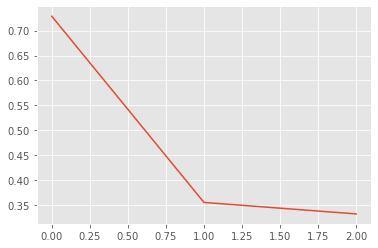

In [13]:
N = 3
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [12]:
history.history

{'loss': [0.7288789749145508, 0.35528385639190674, 0.3322256803512573],
 'acc': [0.7841569781303406, 0.8742732405662537, 0.898982584476471]}

# Moblenet V2

In [10]:
#Not my code
from tensorflow.keras.applications import MobileNetV2

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(200, 200,3))

In [21]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [22]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-4, decay= 1e-4 / 5)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

In [24]:
history = model.fit_generator(train_generator,
                              epochs=5,
                              callbacks=[checkpoint])

Epoch 1/5
138/138 [==============================] - 15s 97ms/step - loss: 0.3230 - accuracy: 0.8931
Epoch 2/5
138/138 [==============================] - 13s 97ms/step - loss: 0.0653 - accuracy: 0.9822
Epoch 3/5
138/138 [==============================] - 14s 99ms/step - loss: 0.0420 - accuracy: 0.9857
Epoch 4/5
138/138 [==============================] - 13s 97ms/step - loss: 0.0200 - accuracy: 0.9955
Epoch 5/5
138/138 [==============================] - 13s 97ms/step - loss: 0.0335 - accuracy: 0.9901


In [25]:
model.save("mask_detector_mobilenet.model", save_format="h5")

In [3]:
model = tf.keras.models.load_model('mask_detector_mobilenet.model')
